In [1]:
!pip install timm
import timm

In [2]:
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset as Dataset
from torch.utils.data import DataLoader as DataLoader
from sklearn import cluster
from zipfile import ZipFile
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from PIL import Image
import pandas as pd
import os
import random
import pickle

torch.cuda.empty_cache()
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = (10,10)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
category_list = {"mountain":0,"street":1,"buildings":2,"sea":3,"forest":4,"glacier":5}
def imglist(train_folder, l=True):
    img = []
    label = []
    i = 0
    for sub_folder in os.listdir(train_folder):
        sub_folder_path = os.path.join(train_folder, sub_folder)
        if os.path.isdir(sub_folder_path):
            for file_name in os.listdir(sub_folder_path):
                if file_name.lower().endswith(".jpg"):
                    img.append(os.path.join(sub_folder_path, file_name))
                    label.append(i)
            i+=1
    if(l):
        combined_data = list(zip(img, label))
        random.shuffle(combined_data)
        img, label = zip(*combined_data)
        return [img, label]
    return img
img, label = imglist("/kaggle/input/intel-image-classification/seg_train/seg_train")
test_img = imglist("/kaggle/input/intel-image-classification/seg_test/seg_test", False)
img = list(img)
label = list(label)
print(len(test_img), len(img))

3000 14034


In [4]:
from collections import Counter
Counter(label)

Counter({0: 2512, 5: 2404, 1: 2382, 3: 2274, 4: 2271, 2: 2191})

In [5]:
x = [0, 0, 0, 0, 0, 0]
i=0
val_img = []
val_label = []
while (x!=[15, 15, 15, 15, 15, 15]):
    l = label[i]
    if x[l]!=15:
        val_img.append(img[i])
        val_label.append(l)
        del label[i], img[i]
        x[l]+=1
        continue     
    i+=1
Counter(val_label)

Counter({3: 15, 5: 15, 4: 15, 1: 15, 0: 15, 2: 15})

In [7]:
batch_size = 16
lr = 0.001
epoch = 30

class Dataset(Dataset):
    def __init__(self,x,y,transform = 'T.Resize((224,224))'):
        self.transform = transform
        self.x = x
        self.y = y
        self.len = len(x)
   
    def __len__(self):
        return self.len
    
    def __getitem__(self,i):
        img = Image.open(self.x[i]).convert('RGB')
        return torch.FloatTensor(np.asarray(self.transform(img))),torch.LongTensor([self.y[i]])

class TestDataset(Dataset):
    def __init__(self,x,transform = 'T.Resize((224,224))'):
        self.transform = transform
        self.x = x
        self.len = len(x)
   
    def __len__(self):
        return self.len
    
    def __getitem__(self,i):
        img = Image.open(self.x[i]).convert('RGB')
        return torch.FloatTensor(np.asarray(self.transform(img)))

transforms_train = T.Compose([
        T.Resize((224,224)),
        T.ToTensor(),
])

transforms_test = T.Compose([
        T.Resize((224,224)),
        T.ToTensor(),
    ])

train_dataset = Dataset(img, label,transform =transforms_train)
validation_dataset = Dataset(val_img, val_label,transform =transforms_test)
test_dataset = TestDataset(test_img,transform =transforms_test)

train_dataloader = DataLoader(train_dataset , batch_size = batch_size , shuffle = True )
validation_dataloader = DataLoader(validation_dataset , batch_size = batch_size , shuffle = True )
test_dataloader = DataLoader(test_dataset , batch_size = batch_size , shuffle = False )

In [9]:
model_name = "vit_tiny_patch16_224"
class ViTBase16(nn.Module):
    def __init__(self, n_classes):

        super(ViTBase16, self).__init__()

        self.model = timm.create_model(model_name, pretrained=True)
        
        self.model.head = nn.Linear(self.model.head.in_features, n_classes)

    def forward(self, x):
        x = self.model(x)
        return x


model = ViTBase16(6)
for param in model.parameters():
    param.requires_grad = True

In [10]:
train_dataset_size = train_dataset.__len__()
validation_dataset_size = validation_dataset.__len__()
train_n_minibatches = train_dataloader.__len__()
validation_n_minibatches = validation_dataloader.__len__()

device = 'cuda'
model.to(device)
loss_history = [[],[]]
accuracy_history = [[],[]] 

results = [[],[]]
kappa = [[],[]]

criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model.parameters(),lr = lr)

In [11]:
from sklearn.metrics import precision_recall_fscore_support, cohen_kappa_score

for e in range(epoch):
    print(f'---------------------------------------EPOCH {e+1}-------------------------------------------')
    y_all_train_true = []
    y_all_train_pred = []
    y_all_val_true = []
    y_all_val_pred = []
    
    for batch_idx , (x ,y) in enumerate(train_dataloader):
        model.train() # Setting mode to train
        optimizer.zero_grad()
        x , y = x.to(device) , y.to(device)
        y_pred = model(x).to(device)
        
        y_all_train_true+=y.cpu().detach().view(-1,).tolist()
        y_all_train_pred+=torch.argmax(y_pred, dim=1).detach().tolist()
        
        # Calculating Loss
        loss = criterion(y_pred,y.reshape(x.shape[0]))
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 3)
        optimizer.step()
        loss_history[0].append(float(loss.detach()))
        
        #Calaculating Accuracy
        correct = 0
        y_pred = y_pred.cpu().detach().numpy().tolist()
        y = y.cpu().detach().numpy().tolist()
        for i in range(x.shape[0]):
            n = 0
            n = y_pred[i].index(max(y_pred[i]))
            if n == y[i][0]:
                correct = correct + 1
        accuracy_history[0].append((correct/x.shape[0])*100)
        
        if batch_idx % (len(train_dataloader)//2) == 0:
            # Printing Log
            print(f'LOSS for EPOCH {e+1} BATCH {batch_idx}/{train_n_minibatches} TRAIN LOSS : {loss_history[0][-1]}',end = ' ')
            print(f'TRAIN ACCURACY : {accuracy_history[0][-1]}',end = ' ')
            with torch.no_grad():
                # Calculating loss and accuracy for validation
                model.eval()
                for _batch_idx_ , (x ,y) in enumerate(validation_dataloader):
                    x , y = x.to(device) , y.to(device)
                    y_pred = model(x).to(device)
                    
                    y_all_val_true+=y.cpu().detach().view(-1,).tolist()
                    y_all_val_pred+=torch.argmax(y_pred, dim=1).detach().tolist()
                    
                    validation_loss = criterion(y_pred,y.reshape(x.shape[0]))
                    loss_history[1].append(float(validation_loss.detach()))
                    
                    correct = 0
                    y_pred = y_pred.cpu().detach().numpy().tolist()
                    y = y.cpu().detach().numpy().tolist()      
                    for i in range(x.shape[0]):
                        n = 0
                        n = y_pred[i].index(max(y_pred[i]))
                        if n == y[i][0]:
                            correct = correct + 1
                    accuracy_history[1].append((correct/x.shape[0])*100)
                        
                    
                print(f'VALIDATION LOSS : {sum(loss_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches}',end = ' ')
                print(f'VALIDATION ACCURACY : {sum(accuracy_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches}')
    
    # Saving the model progress
    torch.save(model.state_dict(),model_name)
    
    results[0].append(precision_recall_fscore_support(y_all_train_true,y_all_train_pred))
    results[1].append(precision_recall_fscore_support(y_all_val_true,y_all_val_pred))

    kappa[0].append(cohen_kappa_score(y_all_train_true,y_all_train_pred))
    kappa[1].append(cohen_kappa_score(y_all_val_true,y_all_val_pred))
    print(f'--------------------------------------------------------------------------------------------')
    print(f'Loss for EPOCH {e+1}  TRAIN LOSS : {sum(loss_history[0][-1:-train_n_minibatches-1:-1])/train_n_minibatches}',end = ' ')
    print(f'TRAIN PREC : {results[0][-1][0]} RECALL : {results[0][-1][1]} F1 : {results[0][-1][2]}',end=" ")
    print(f'ACC : {sum(accuracy_history[0][-1:-train_n_minibatches-1:-1])/train_n_minibatches}', end=" ")
    print(f' KAPPA : {sum(kappa[0][-1:-1*validation_n_minibatches-1:-1])/validation_n_minibatches}')
    print(f'VALIDATION LOSS for EPOCH {e+1} : {sum(loss_history[1][-1:-1*validation_n_minibatches-1:-1])/validation_n_minibatches}',end = ' ')
    print(f'VALIDATION PREC : {results[1][-1][0]} RECALL : {results[1][-1][1]} F1 : {results[1][-1][2]}',end=" ")
    print(f' ACC : {sum(accuracy_history[1][-1:-1*validation_n_minibatches-1:-1])/validation_n_minibatches}',end=" ")
    print(f' KAPPA : {sum(kappa[1][-1:-1*validation_n_minibatches-1:-1])/validation_n_minibatches}')
    print('---------------------------------------------------------------------------------------------')

---------------------------------------EPOCH 1-------------------------------------------
LOSS for EPOCH 1 BATCH 0/872 TRAIN LOSS : 3.6742801666259766 TRAIN ACCURACY : 12.5 VALIDATION LOSS : 4.050707101821899 VALIDATION ACCURACY : 10.0
LOSS for EPOCH 1 BATCH 436/872 TRAIN LOSS : 0.2955733835697174 TRAIN ACCURACY : 87.5 VALIDATION LOSS : 0.29920754705866176 VALIDATION ACCURACY : 90.625
--------------------------------------------------------------------------------------------
Loss for EPOCH 1  TRAIN LOSS : 0.654777485198008 TRAIN PREC : [0.69282511 0.79279661 0.820857   0.80793226 0.88824834 0.6986246 ] RECALL : [0.74249099 0.79045205 0.73069853 0.80256751 0.88785461 0.72289661] F1 : [0.71679876 0.79162259 0.77315828 0.80524095 0.88805143 0.71055338] ACC : 77.87413990825688  KAPPA : 0.12236583354812931
VALIDATION LOSS for EPOCH 1 : 0.29920754705866176 VALIDATION PREC : [0.34920635 0.58333333 0.8125     0.57142857 0.53571429 0.5       ] RECALL : [0.73333333 0.46666667 0.43333333 0.4    

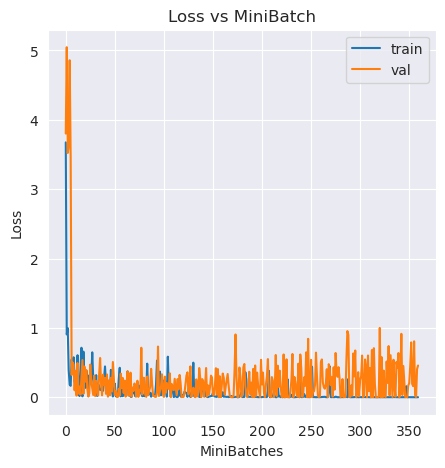

In [106]:
plt.figure(figsize=(5, 5))
plt.plot(range(len(loss_history[1])), loss_history[0][::len(loss_history[0])//len(loss_history[1])][:len(loss_history[1])], label='train')
plt.plot(range(len(loss_history[1])), loss_history[1], label='val')
plt.legend(loc='upper right')
plt.title("Loss vs MiniBatch")
plt.xlabel('MiniBatches')
plt.ylabel('Loss')
plt.show()


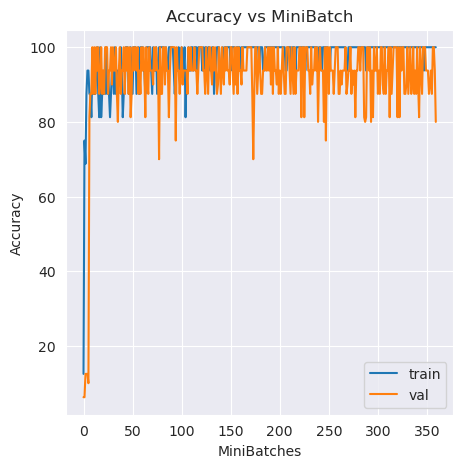

In [104]:
plt.figure(figsize=(5, 5))
train_accuracy = accuracy_history[0][::len(accuracy_history[0]) // len(accuracy_history[1])][:len(accuracy_history[1])]
plt.plot(range(len(accuracy_history[1])), train_accuracy, label='train')
plt.plot(range(len(accuracy_history[1])), accuracy_history[1], label='val')
plt.legend(loc='lower right')
plt.title("Accuracy vs MiniBatch")
plt.xlabel('MiniBatches')
plt.ylabel('Accuracy')
plt.show()

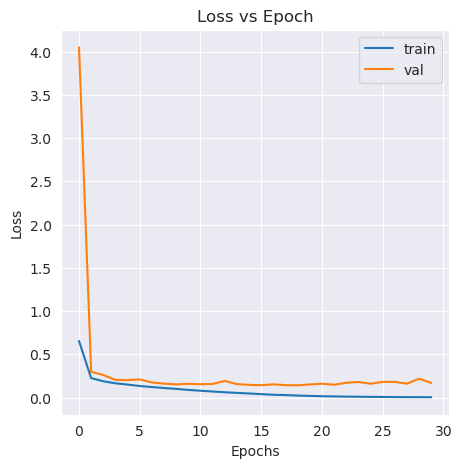

In [102]:
loss_per_epoch = [[],[]]
for i in range(epoch):
    temp = 0
    for j in loss_history[0][i*train_n_minibatches:(i+1)*train_n_minibatches]:
        temp = temp + j
    loss_per_epoch[0].append(temp/train_n_minibatches)
    temp = 0
    for j in loss_history[1][i*validation_n_minibatches:(i+1)*validation_n_minibatches]:
        temp = temp + j
    loss_per_epoch[1].append(temp/validation_n_minibatches)
    
plt.figure(figsize=(5, 5))
plt.plot(range(len(loss_per_epoch[0])), loss_per_epoch[0], label='train')
plt.plot(range(len(loss_per_epoch[1])), loss_per_epoch[1], label='val')
plt.legend(loc='upper right')
plt.title("Loss vs Epoch")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

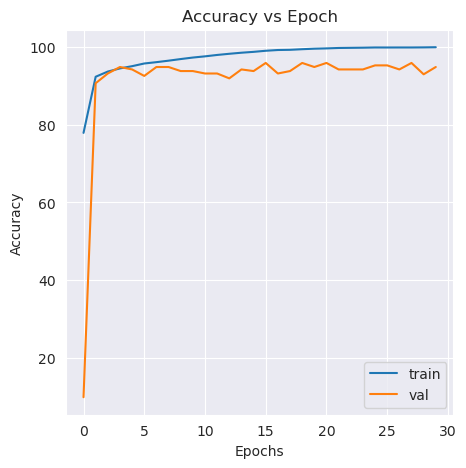

In [100]:
accuracy_per_epoch = [[],[]]
for i in range(epoch):
    temp = 0
    for j in accuracy_history[0][i*train_n_minibatches:(i+1)*train_n_minibatches]:
        temp = temp + j
    accuracy_per_epoch[0].append(temp/train_n_minibatches)
    temp = 0
    for j in accuracy_history[1][i*validation_n_minibatches:(i+1)*validation_n_minibatches]:
        temp = temp + j
    accuracy_per_epoch[1].append(temp/validation_n_minibatches)    

plt.figure(figsize=(5, 5)) 
plt.plot(range(len(accuracy_per_epoch[0])), accuracy_per_epoch[0], label='train')
plt.plot(range(len(accuracy_per_epoch[1])), accuracy_per_epoch[1], label='val')
plt.legend(loc='lower right')
plt.title("Accuracy vs Epoch")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

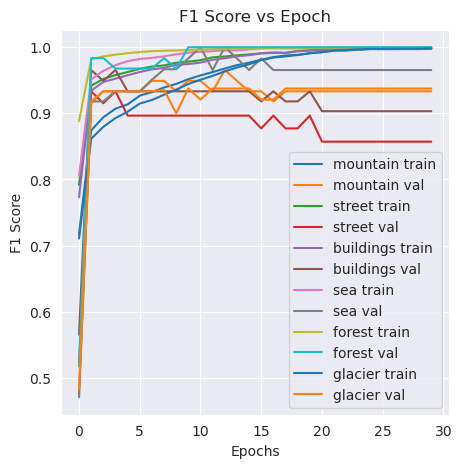

In [99]:
labels = {0:"mountain",1:"street",2:"buildings",3:"sea",4:"forest",5:"glacier"}
legend = []
plt.figure(figsize=(5, 5))
legend = []
for j in range(6):
    plt.plot(range(len(results[0])), [results[0][i][2][j] for i in range(len(results[0]))], label=labels[j] + ' train')
    plt.plot(range(len(results[1])), [results[1][i][2][j] for i in range(len(results[1]))], label=labels[j] + ' val')
    legend += [labels[j] + ' train', labels[j] + ' val']
plt.legend(loc='lower right', labels=legend)
plt.title("F1 Score vs Epoch")
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.show()


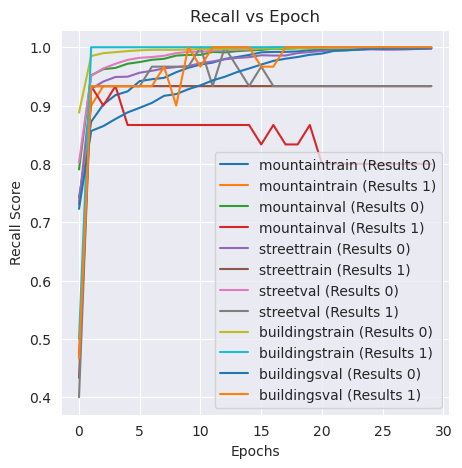

In [98]:
plt.figure(figsize=(5, 5))
for j in range(6):
    recall_scores_0 = [results[0][i][1][j] for i in range(len(results[0]))]
    plt.plot(range(len(recall_scores_0)), recall_scores_0, label=f"{legend[j]} (Results 0)")
    recall_scores_1 = [results[1][i][1][j] for i in range(len(results[1]))]
    plt.plot(range(len(recall_scores_1)), recall_scores_1, label=f"{legend[j]} (Results 1)")
plt.legend(loc='lower right')
plt.title("Recall vs Epoch")
plt.xlabel('Epochs')
plt.ylabel('Recall Score')
plt.show()


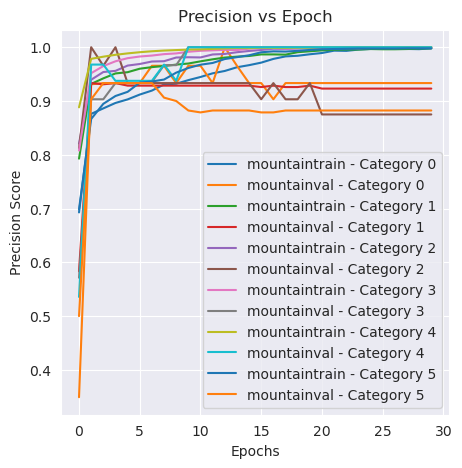

In [96]:
plt.figure(figsize=(5, 5))
for j in range(6):
    precision_scores_0 = [results[0][i][0][j] for i in range(len(results[0]))]
    precision_scores_1 = [results[1][i][0][j] for i in range(len(results[1]))]
    plt.plot(range(len(precision_scores_0)), precision_scores_0, label=f'{legend[0]} - Category {j}')
    plt.plot(range(len(precision_scores_1)), precision_scores_1, label=f'{legend[1]} - Category {j}')
plt.legend(loc='lower right')
plt.title("Precision vs Epoch")
plt.xlabel('Epochs')
plt.ylabel('Precision Score')
plt.show()

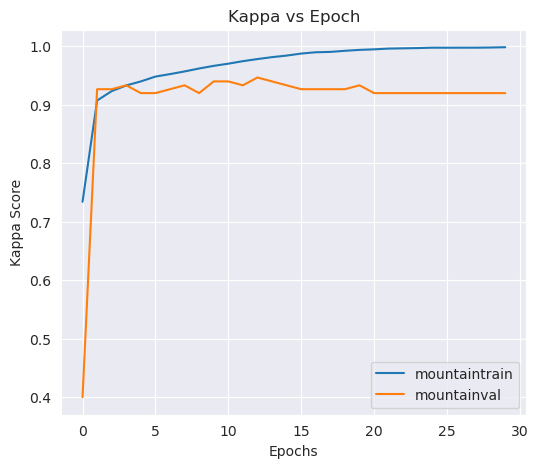

In [95]:
plt.figure(figsize=(6, 5))
plt.plot(range(len(kappa[0])), kappa[0], label=legend[0])
plt.plot(range(len(kappa[1])), kappa[1], label=legend[1])
plt.legend(loc='lower right')
plt.title("Kappa vs Epoch")
plt.xlabel('Epochs')
plt.ylabel('Kappa Score')
plt.show()


In [32]:
class TestDataset(Dataset):
    def __init__(self,x,transform = 'T.Resize((224,224))'):
        self.transform = transform
        self.x = x
        self.len = len(x)
   
    def __len__(self):
        return self.len
    
    def __getitem__(self,i):
        img = Image.open(self.x[i]).convert('RGB')
        return torch.FloatTensor(np.asarray(self.transform(img)))
    
test_dataset = TestDataset(test_img,transform =transforms_test)
test_dataloader = DataLoader(test_dataset , batch_size = batch_size , shuffle = False )

predictions = []
with torch.no_grad():
    model.eval()
    for _batch_idx_ , x in enumerate(test_dataloader):
        x = x.to(device)
        y_pred = model(x).to(device)
        pred = torch.argmax(y_pred, dim=1)
        predictions+=pred.cpu().tolist()

In [81]:
df = pd.DataFrame(list(zip([test_img[i].split('/')[-2] for i in range(len(test_img))], predictions)), index =None, columns =['image', 'category'])
df['category'] = df['category'].map(labels)
df = df.rename(columns={'image': 'true_image', 'category': 'pred_image'})
df.to_csv("submission.csv", index=False)
correct_predictions = (df['true_image'] == df['pred_image']).sum()
total_predictions = len(df)
test_accuracy = correct_predictions / total_predictions
df = df.sample(frac=1).reset_index(drop=True)
print(df.head(25))
print(f"Test Accuracy: {test_accuracy:.2%}")

   true_image pred_image
0      forest     forest
1     glacier    glacier
2     glacier    glacier
3         sea        sea
4    mountain   mountain
5     glacier    glacier
6      forest     forest
7    mountain   mountain
8      street     street
9         sea        sea
10        sea        sea
11     forest     forest
12    glacier   mountain
13   mountain   mountain
14  buildings  buildings
15        sea        sea
16        sea        sea
17  buildings  buildings
18     forest     forest
19  buildings  buildings
20     forest     forest
21     forest     forest
22    glacier    glacier
23     forest     forest
24  buildings  buildings
Test Accuracy: 93.67%


In [107]:
labels = {0: "mountain", 1: "street", 2: "buildings", 3: "sea", 4: "forest", 5: "glacier"}
df1 = pd.DataFrame(list(zip(test_img, predictions)), columns=['image', 'category'])
df1['category'] = df1['category'].map(labels)
print(df1)

                                                  image  category
0     /kaggle/input/intel-image-classification/seg_t...  mountain
1     /kaggle/input/intel-image-classification/seg_t...   glacier
2     /kaggle/input/intel-image-classification/seg_t...  mountain
3     /kaggle/input/intel-image-classification/seg_t...  mountain
4     /kaggle/input/intel-image-classification/seg_t...  mountain
...                                                 ...       ...
2995  /kaggle/input/intel-image-classification/seg_t...   glacier
2996  /kaggle/input/intel-image-classification/seg_t...   glacier
2997  /kaggle/input/intel-image-classification/seg_t...   glacier
2998  /kaggle/input/intel-image-classification/seg_t...  mountain
2999  /kaggle/input/intel-image-classification/seg_t...   glacier

[3000 rows x 2 columns]
